In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('yoga-pose-classifier')
jovian.set_colab_id('1q8EG58wWneQFS0-ySFQ90pwOeHdW4-4u')

# course-note

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="course-note")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/varadk24022002/course-note


'https://jovian.ai/varadk24022002/course-note'

In [ ]:
!pip install opendatasets --upgrade --quiet

#**Preparing the Yoga Pose Image classification Dataset**
This notebook is for Image Classification using ResNet in PyTorch, where we trained a deep convolutional neural network to classify images from the Yoga Pose Image dataset with around 70% accuracy.

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/shrutisaxena/yoga-pose-image-classification-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: varadkottawar
Your Kaggle Key: ··········


  1%|          | 9.00M/0.98G [00:00<00:19, 54.6MB/s]

100%|██████████| 0.98G/0.98G [00:10<00:00, 98.0MB/s]


Below is the list of the names of the output classes in the dataset.
In our cases these are the names of the Yoga positions.

In [ ]:
#cacf1d9e5fe8d36af65f79aac5895f4e
import os

DATA_DIR = '/content/yoga-pose-image-classification-dataset/dataset'
classes = os.listdir(DATA_DIR)
print(classes)

['parivrtta trikonasana', 'tittibhasana', 'urdhva mukha svanasana', 'parsva bakasana', 'supta virasana', 'simhasana', 'salabhasana', 'salamba sarvangasana', 'utthita hasta padangustasana', 'eka pada rajakapotasana ii', 'prasarita padottanasana', 'yoganidrasana', 'kurmasana', 'vajrasana', 'dandasana', 'tulasana', 'sukhasana', 'astavakrasana', 'mayurasana', 'kapotasana', 'parighasana', 'eka pada rajakapotasana', 'lolasana', 'virabhadrasana ii', 'setu bandha sarvangasana', 'utthita ashwa sanchalanasana', 'ananda balasana', 'virasana', 'bakasana', 'bhairavasana', 'durvasasana', 'krounchasana', 'malasana', 'tadasana', 'supta padangusthasana', 'marichyasana iii', 'ardha pincha mayurasana', 'urdhva hastasana', 'uttana shishosana', 'pasasana', 'janu sirsasana', 'camatkarasana', 'uttanasana', 'supta baddha konasana', 'chaturanga dandasana', 'agnistambhasana', 'vrischikasana', 'hanumanasana', 'utthita trikonasana', 'purvottanasana', 'baddha konasana', 'adho mukha vriksasana', 'ardha matsyendrasa

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(DATA_DIR, transform=ToTensor())

In [ ]:
import torch
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

The dataset which we are using does not images with same shapes.
Our model requires images with same dimesnions. This code cell helps us in making dimensions same.
There are other functions present as well which increases the performance of our model.

In [ ]:
import torchvision.transforms as T

image_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

dataset = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomRotation(10),
    T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
    T.Normalize(*stats)]))

In next cell we split our dataset in training and validation dataset.
Since this is a small dataset, we here use only 10% of our original dataset as validation dataset. Generally 40% is suggested.

In [ ]:
from torch.utils.data import random_split

val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

Here we will be creating dataloaders that we will using for loading our dataset to the model

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.utils import make_grid

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

Here are some of the images from our dataset.


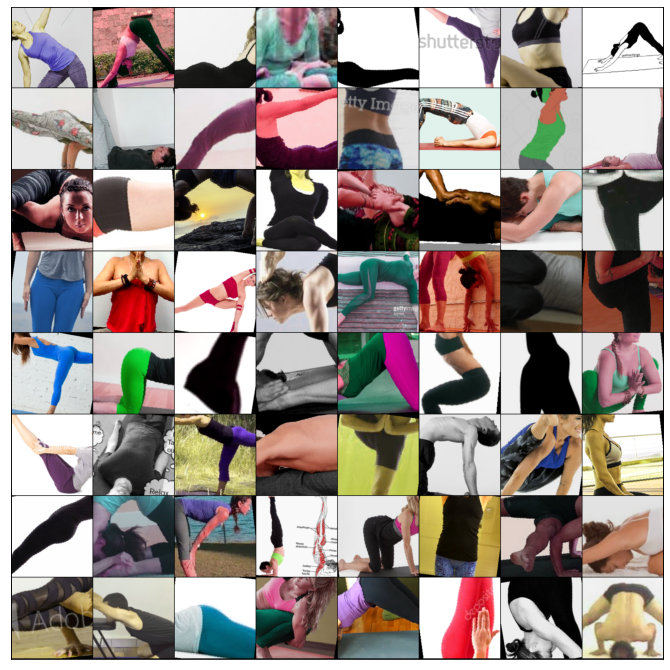

In [ ]:
show_batch(train_dl)

Next code cell helps us in calculating the accuracy and losses our model is creating.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

#Modifying a Pretrained Model (ResNet34)
We are using a pretrained ResNet34 model here.
As the name itself suggest that the model is pretrained, which means that parameters already have some calculated values, our model just imporves it according to our dataset. 

In [ ]:
from torchvision import models

class YogaModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

#Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#Training the model
we are using techniques, that will increase the performance if our model, such as **Learning rate scheduling, Weight decay, Gradient clipping**
These are some articles that will help you in learning more about them

https://sgugger.github.io/the-1cycle-policy.html

https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#Creating our model

In [ ]:
model = YogaModel(len(classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.010416666977107525, 'val_loss': 4.848141670227051}]

Here we define our hyperparameters

In [ ]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

We begin the traing of our model

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [0],last_lr: 0.00027, train_loss: 4.2444, val_loss: 3.1360, val_acc: 0.2585


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [1],last_lr: 0.00076, train_loss: 2.2805, val_loss: 2.7934, val_acc: 0.3141


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [2],last_lr: 0.00100, train_loss: 1.6816, val_loss: 2.4676, val_acc: 0.3610


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [3],last_lr: 0.00095, train_loss: 1.4591, val_loss: 1.9822, val_acc: 0.4707


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [4],last_lr: 0.00081, train_loss: 1.1147, val_loss: 1.6468, val_acc: 0.5367


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [5],last_lr: 0.00061, train_loss: 0.8432, val_loss: 1.5612, val_acc: 0.5444


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [6],last_lr: 0.00039, train_loss: 0.5906, val_loss: 1.2813, val_acc: 0.6323


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [7],last_lr: 0.00019, train_loss: 0.3789, val_loss: 1.1954, val_acc: 0.6557


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [8],last_lr: 0.00005, train_loss: 0.2675, val_loss: 1.1599, val_acc: 0.6828


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch [9],last_lr: 0.00000, train_loss: 0.2180, val_loss: 1.1578, val_acc: 0.6711
CPU times: user 2min 16s, sys: 2min 13s, total: 4min 29s
Wall time: 14min 31s


#**Predictions**
Here we will be testing our model by passing individual images and obtaining the predicted values.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: eka pada rajakapotasana , Predicted: eka pada rajakapotasana


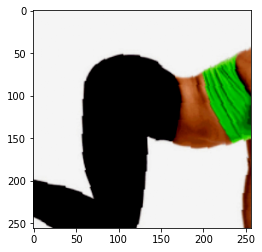

In [ ]:
img, label = valid_ds[105]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))